In [22]:
pip install scikit-learn

     --------------------------------------- 11.1/11.1 MB 34.4 MB/s eta 0:00:00
     ------------------------------------- 301.8/301.8 kB 18.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
#pip install quandl
#pip install scipy
#!pip install seaborn
#!pip install statsmodels
#import yfinance as yf
#import sklearn
#from sklearn.decomposition import PCA
#from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
#from scipy.spatial.distance import squareform

In [8]:
import pandas as pd
import sys  # For exiting if file reading fails

# File paths and corresponding column names for merging
file_info = {
    "equity_emea": r"C:\Users\Nicolas\Downloads\LU1689734546.csv",
    "bonds_high_yield": r"C:\Users\Nicolas\Downloads\LU1689731369.csv",
}

def load_and_clean_data(filepath, price_col_name):
    """
    Reads a CSV file, keeps only 'date' and 'clot' columns, cleans data, and returns a DataFrame.
    
        Parameters:
        - filepath (str): Path to the CSV file
        - price_col_name (str): Name to assign to the 'clot' column after reading
    
    Returns:
    - pd.DataFrame: Cleaned DataFrame with 'date' as index and renamed 'clot' column
    """
    try:
        df = pd.read_csv(filepath, delimiter=",", usecols=["date", "clot"], parse_dates=["date"])
        df.rename(columns={"clot": price_col_name}, inplace=True)
        df.set_index("date", inplace=True)
        df = df[~df.index.duplicated(keep="first")].dropna()  # Remove duplicates & NaNs
        return df
    except Exception as e:
        print(f"❌ Error reading {filepath}: {e}")
        sys.exit(1)  # Stop execution if file cannot be loaded


# Load and clean datasets
dataframes = {name: load_and_clean_data(path, name) for name, path in file_info.items()}

# Find common date range across all datasets
common_start = max(df.index.min() for df in dataframes.values())
common_end = min(df.index.max() for df in dataframes.values())

# Filter all datasets to the common date range
dataframes = {name: df.loc[common_start:common_end] for name, df in dataframes.items()}

# Merge all datasets using 'date' as the index
merged_df = pd.concat(dataframes.values(), axis=1, join="inner").round(decimals=2)

# Save cleaned data
merged_df.to_csv("cleaned_stock_prices.csv")

# Show first few rows
print(merged_df.head())

            equity_emea  bonds_high_yield
date                                     
2024-01-19       121.14            157.34
2024-01-22       120.72            157.70
2024-01-23       121.31            157.94
2024-01-24       123.23            157.96
2024-01-25       123.49            158.07


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_2952\510949233.py:22: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(filepath, delimiter=",", usecols=["date", "clot"], parse_dates=["date"])
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_2952\510949233.py:22: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(filepath, delimiter=",", usecols=["date", "clot"], parse_dates=["date"])


In [9]:
## Functions to visualize data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf


# Plot time series data
def plot_price_trends(df):
    """Plot the price trends of all columns."""
    plt.figure(figsize=(12, 6))
    for column in df.columns:
        plt.plot(df.index, df[column], label=column)
    plt.legend()
    plt.title("Price Trends")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid()
    plt.show()

# Moving averages
def plot_moving_averages(df, window=20):
    """Plot simple and exponential moving averages."""
    plt.figure(figsize=(12, 6))
    for column in df.columns:
        plt.plot(df[column], label=f"{column} Price")
        plt.plot(df[column].rolling(window).mean(), linestyle="dashed", label=f"{column} {window}D SMA")
        plt.plot(df[column].ewm(span=window).mean(), linestyle="dotted", label=f"{column} {window}D EMA")
    plt.legend()
    plt.title("Moving Averages")
    plt.show()

# Rolling volatility
def plot_rolling_volatility(df, window=20):
    """Plot rolling standard deviation to measure volatility."""
    plt.figure(figsize=(12, 6))
    for column in df.columns:
        plt.plot(df[column].rolling(window).std(), label=f"{column} Volatility")
    plt.legend()
    plt.title("Rolling Volatility (Std Dev)")
    plt.show()

# Correlation heatmap
def plot_correlation_heatmap(df):
    """Plot a heatmap of the correlation between different time series."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

# Returns analysis in percentage format
def calculate_returns(df, method="daily"):

    daily_returns = df.pct_change().dropna() * 100  # Convert to percentage

    if method == "daily":
        cumulative_returns = ((1 + df.pct_change()).cumprod() - 1) * 100
    elif method == "monthly":
        monthly_returns = df.resample('M').ffill().pct_change().dropna()
        cumulative_returns = ((1 + monthly_returns).cumprod() - 1) * 100
    elif method == "continuous":
        log_returns = np.log(df / df.shift(1))
        cumulative_returns = (log_returns.cumsum()) * 100  # Log returns are additive
    else:
        raise ValueError("Method must be 'daily', 'monthly', or 'continuous'.")

    return daily_returns, cumulative_returns


# Plot daily returns histogram
def plot_returns_distribution(daily_returns):
    """Plot histogram of daily returns for all assets."""
    plt.figure(figsize=(12, 6))
    for column in daily_returns.columns:
        sns.histplot(daily_returns[column], bins=50, kde=True, label=column, alpha=0.6)
    plt.legend()
    plt.title("Histogram of Daily Returns")
    plt.show()

# Plot cumulative returns
def plot_cumulative_returns(cumulative_returns):
    """Plot cumulative returns over time."""
    plt.figure(figsize=(12, 6))
    for column in cumulative_returns.columns:
        plt.plot(cumulative_returns[column], label=column)
    plt.legend()
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.show()

# Autocorrelation plot
def plot_autocorrelation(daily_returns, lags=30):
    """Plot autocorrelation of returns for each asset."""
    for column in daily_returns.columns:
        plot_acf(daily_returns[column].dropna(), lags=lags, title=f"Autocorrelation of {column} Returns")
        plt.show()

# Main function to run all analyses
def analyze_time_series(merged_df):
    """Perform all time series analyses and visualizations."""
    plot_price_trends(merged_df)
    plot_moving_averages(merged_df)
    plot_rolling_volatility(merged_df)
    plot_correlation_heatmap(merged_df)
    
    daily_returns, cumulative_returns = calculate_returns(merged_df, method="monthly")

    plot_returns_distribution(daily_returns)
    plot_cumulative_returns(cumulative_returns)
    plot_autocorrelation(daily_returns)

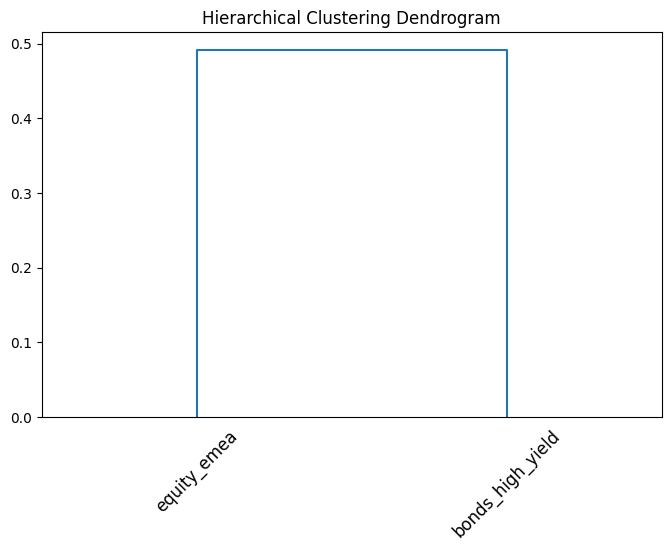


PCA Selected Assets: ['equity_emea', 'bonds_high_yield']
Hierarchical Clustering Selected Assets: ['equity_emea', 'bonds_high_yield']
Rolling Correlation Dispersion Selected Assets: ['equity_emea', 'bonds_high_yield']


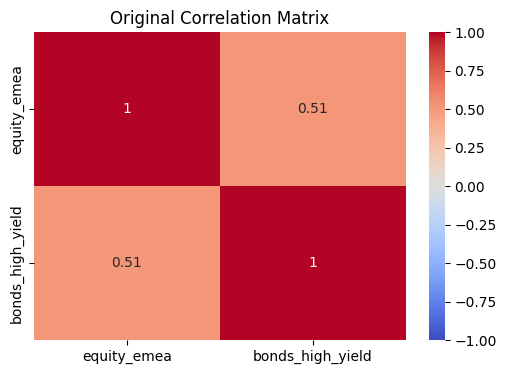

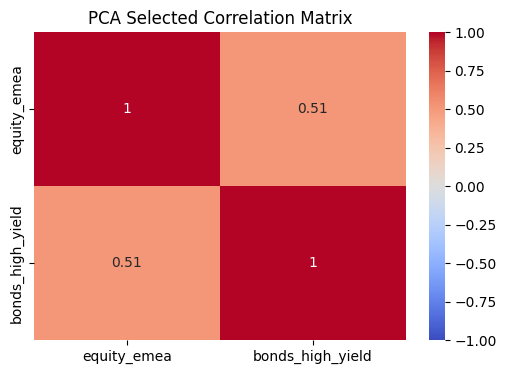

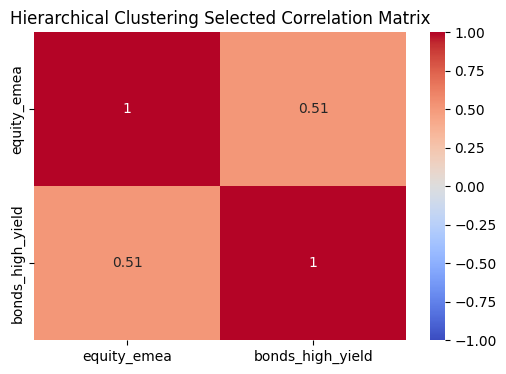

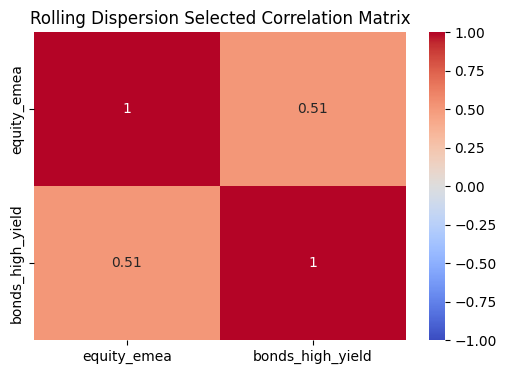

In [27]:
def apply_pca(returns, n_assets):
    """ Selects least correlated assets using total PCA loadings """
    pca = PCA()
    pca.fit(returns)
    
    # Sum of absolute loadings across all principal components
    total_loadings = np.sum(np.abs(pca.components_), axis=0)
    
    # Select assets with the smallest total PCA loading
    selected_assets = np.argsort(total_loadings)[:n_assets]
    
    return returns.columns[selected_assets]

def hierarchical_clustering(returns, n_assets):
    """ Uses hierarchical clustering to select the most diversified assets """
    corr_matrix = returns.corr()
    dist_matrix = 1 - corr_matrix  # Convert correlation to distance
    linkage_matrix = linkage(squareform(dist_matrix), method='ward')
    
    # Visualize dendrogram
    plt.figure(figsize=(8, 5))
    dendrogram(linkage_matrix, labels=returns.columns, leaf_rotation=45)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.show()
    
    # Cut tree to get n clusters
    clusters = fcluster(linkage_matrix, t=n_assets, criterion='maxclust')
    
    # Select most distant assets within clusters
    cluster_dict = {}
    for i, cluster in enumerate(clusters):
        if cluster not in cluster_dict:
            cluster_dict[cluster] = [i]
        else:
            cluster_dict[cluster].append(i)
    
    # Select the most distant representative per cluster
    selected_assets = [returns.columns[min(indices)] for cluster, indices in cluster_dict.items()]
    
    return selected_assets

def rolling_correlation_dispersion(returns, n_assets, window=3):
    """ Selects assets with lowest rolling correlation dispersion """
    rolling_corrs = returns.rolling(window=window).corr()
    
    # Compute mean dispersion over time for each asset
    dispersion = rolling_corrs.groupby(level=0).std().mean()
    
    # Select assets with lowest average dispersion
    selected_assets = dispersion.nsmallest(n_assets).index
    
    return selected_assets

def visualize_correlation(returns, selected_assets, title="Correlation Matrix"):
    """ Visualizes correlation matrix before and after selection """
    plt.figure(figsize=(6, 4))
    sns.heatmap(returns[selected_assets].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()


def main():
    n_assets = 2  # Set number of assets to select
    returns = daily_returns
    
    # PCA Selection
    pca_selected = apply_pca(returns, n_assets)
    
    # Hierarchical Clustering Selection
    hc_selected = hierarchical_clustering(returns, n_assets)
    
    # Rolling Correlation Dispersion
    rcd_selected = rolling_correlation_dispersion(returns, n_assets)
    
    print("\nPCA Selected Assets:", list(pca_selected))
    print("Hierarchical Clustering Selected Assets:", list(hc_selected))
    print("Rolling Correlation Dispersion Selected Assets:", list(rcd_selected))
    
    # Correlation matrix visualization
    visualize_correlation(returns, returns.columns, "Original Correlation Matrix")
    visualize_correlation(returns, pca_selected, "PCA Selected Correlation Matrix")
    visualize_correlation(returns, hc_selected, "Hierarchical Clustering Selected Correlation Matrix")
    visualize_correlation(returns, rcd_selected, "Rolling Dispersion Selected Correlation Matrix")

if __name__ == "__main__":
    main()